<a href="https://colab.research.google.com/github/evgeny-kolonsky/Lab4/blob/main/SP/Camera_measurements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size=6> Wavelengths measurements with digital camera</font>

Evgeny Kolonsky, 2025

v.0.3.3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from scipy.optimize import fsolve
from math import degrees as deg

# Model

Theoretical expression for light diffraction when incident light assumed to be perpendicutalr to lattice is
$$
n \lambda = d \sin \beta_n,
\tag{1}
$$
where $\lambda$ - light wave length, $d$ - diffraction grating parameter, $n$ - order number, $\beta_n$ - deviation angle of order $n$ light beam.

When incident light falls under an arbitrary angle $\alpha_0$ to lattice plane perpendicular, the expression is written in form
$$ 2 d \sin\frac{\beta_n}{2} \cos\left(\alpha_0 +\frac{\beta_n}{2}\right)
= n \lambda
, \quad n =  \pm 1, \pm 2, ..
\tag{2}
$$
Here $\beta_n$ is the angle between incident light beam and  deviated beam of order $n$, which we can measure rather accurately in optical spectroscopy experiment.

For $\alpha_0=0$ (light falls ⟂) we receive eq.(1).

Otherwise we expect to see non-symmetry in deviation angles $\beta_{\pm n}$ .

## Lattice angle position


We can neither ensure $\alpha_0=0$ nor accurately measure $\alpha_0$ directly due to construction of the experiment set.

The unknown angle $\alpha_0$ between lattice plane perpendicular and light beam can be found indirectly by measuring $\beta_{\pm 1}$, even when lattice period $d$ and wavelength $\lambda$ are also unknown. For a pair $\pm n$ using eq.(2) we have  
$$
\sin \frac{\beta_{+n}}{2} \cos\left( \alpha_0 + \frac{\beta_{+n}}{2}\right) + \sin \frac{\beta_{-n}}{2} \cos\left( \alpha_0 + \frac{\beta_{-n}}{2}\right) =0.   
$$
We have one equation with one unknown parameter $\alpha_0$. It can be easiliy solved analytically. Denoting for first series $n=\pm1$
$$
c_{1} = \cos\frac{\beta_{+1}}{2}, \quad s_{1} = \sin\frac{\beta_{+1}}{2}, \\
c_{2} = \cos\frac{\beta_{-1}}{2}, \quad s_{2} = \sin\frac{\beta_{-1}}{2}, \\
C = c_{1} s_{1} + c_{2} s_{2}, \quad
D = s_{1}^2 + s_{2}^2
$$
we found
$$
\alpha_0 = \arccos\frac{D}{\sqrt{C^2+D^2}}.
$$
Since we measure $\beta_n$ rather accurately, accuracy of $\alpha_0$ is also reasonably high. Uncertainty of $\alpha_0$ can be decreased further by averaging $\alpha_0$ for all known pairs.  

In [2]:
def get_alpha0(beta_plus, beta_minus):
  c1 = np.cos(beta_plus/2)
  s1 = np.sin(beta_plus/2)
  c2 = np.cos(beta_minus/2)
  s2 = np.sin(beta_minus/2)
  D = s1*s1 + s2*s2
  C = c1*s1 + c2*s2
  acos =  D / np.sqrt(C*C + D*D)
  alpha0_arr = np.arccos(acos)
  alpha0 = np.mean(alpha0_arr)
  alpha0_err = np.std(alpha0_arr) / np.sqrt(len(alpha0_arr) - 1)
  return alpha0, alpha0_err

def get_pairs(beta, colors, orders):
  def get_pair(color_ind, order):
    beta_plus = beta[(color_index == color_ind) & (n == order)]
    beta_minus = beta[(color_index == color_ind) & (n == -order)]
    if len(beta_plus) == 1 and len(beta_minus) == 1:
      return (beta_plus[0], beta_minus[0])
    else:
      return None
  betas = [get_pair(color_ind, order) for color_ind in np.unique(colors) for order in np.unique(orders)]
  beta_plus = np.array([b[0] for b in betas if b is not None])
  beta_minus = np.array([b[1] for b in betas if b is not None])
  return beta_plus, beta_minus

# Measurements

## Helium

Measured with spectrograph

![He](https://github.com/tphlabs/data/blob/main/Lab4_SP/helium.png?raw=true')

In [15]:
colors = ['Unidentified', '1 Blue448', '2 Blue472', 
          '3 Green492', '4 Green501', '5 Yellow588', '6 Red668', '7 Red707']
python_colors = ['gray',  'blue', 'lightblue', 'lightgreen', 'green', 'yellow', 'red', 'black']
nominal_waves = [np.NaN,  448, 472, 492, 501, 588, 668, 707]


measurements = '''
# order, coor_index beta(degrees)
1 1 12.87
1 2 13.59
1 3 14.175
1 4 14.49
1 5 17.01
1 6 19.35
1 7 20.565
-1 1 -12.915
-1 2 -13.59
-1 3 -14.22
-1 4 -14.49
-1 5 -17.055
-1 6 -19.485
-1 7 -20.655
'''

n, color_index, beta = np.genfromtxt(measurements.splitlines(), unpack=True)


beta *= np.pi / 180

beta_plus, beta_minus = get_pairs(beta, color_index, n)

alpha0, alpha0_err = get_alpha0(beta_plus, beta_minus)
print(f'alpha0: {deg(alpha0):.1f} ± {deg(alpha0_err):.1f} degree')


#beta_yellow = beta[color_index == 6]
#n_yellow = n[color_index == 6]
#d_arr = n_yellow * lmbd_yellow / ( 2 * np.sin(beta_yellow/2) * np.cos(-alpha0 + beta_yellow/2) )

lmbd = [nominal_waves[int(clr)]*1e-9 for clr in color_index]
d_arr = n * lmbd / ( 2 * np.sin(beta/2) * np.cos(-alpha0 + beta/2) )

d = np.mean(d_arr)
d_err = np.std(d_arr) / np.sqrt(len(d_arr) - 1)
print(rf'Calculated d = {d *1e6:.3f} ± {d_err*1e6:.3f} um')
#d = 2e-6 # 500 lines per mm
print(f'Nominal d is 500 lines per mm {d*1e6:0.1f} um')


alpha0: 0.6 ± 0.1 degree
Calculated d = 2.007 ± 0.001 um
Nominal d is 500 lines per mm 2.0 um


2 Blue472      : lambda = 471.6 ± 0.5 nm, 2 points
3 Green492     : lambda = 492.3 ± 0.2 nm, 2 points
4 Green501     : lambda = 502.2 ± 0.6 nm, 2 points
5 Yellow588    : lambda = 587.9 ± 0.1 nm, 2 points
6 Red668       : lambda = 667.3 ± 1.1 nm, 2 points
7 Red707       : lambda = 706.5 ± 0.2 nm, 2 points


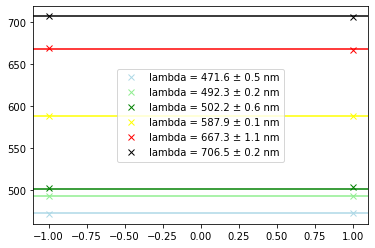

In [11]:
for ix in range(2, len(colors)):
  b = beta[color_index == ix]
  n_ix =  n[color_index == ix]
  lmbd = 2 * d *  np.sin(b / 2) * np.cos(-alpha0 + b / 2) /n_ix
  lmbd_mean = np.mean(lmbd)
  lmbd_err = np.std(lmbd) / np.sqrt(len(lmbd) - 1)
  lmbd_n = len(lmbd)
  print(rf'{colors[ix]:<15}: lambda = {lmbd_mean*1e9:.1f} ± {lmbd_err*1e9:.1f} nm, {lmbd_n:d} points' )

  plt.plot(n_ix, 2 * d *  np.sin(b / 2) * np.cos(-alpha0 + b / 2) /n_ix *1e9, 'x', color=python_colors[ix],
           label=f'lambda = {lmbd_mean*1e9:.1f} ± {lmbd_err*1e9:.1f} nm')
  plt.axhline(nominal_waves[ix], color=python_colors[ix])
  plt.legend()


## Hydrogen

Measured with spectrograph

![H](https://github.com/tphlabs/data/blob/main/Lab4_SP/hydrogen.png?raw=true')

d = 2.007 um
alpha0: 0.8 ± 0.2 degree
Violet 434     : lambda = 434.7 ± 0.9 nm, 2 points
Cian 486       : lambda = 486.0 ± 0.3 nm, 4 points
Red 657        : lambda = 656.5 ± 0.6 nm, 4 points


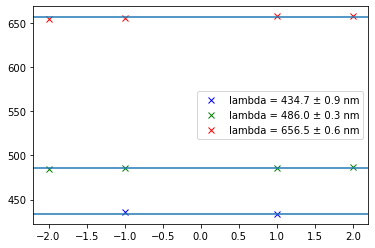

In [16]:
colors = ['Unidentified', 'Violet 434', 'Cian 486', 'Red 657']
python_colors = ['gray', 'blue', 'green', 'red']
nominal_waves = [np.NaN, 434, 486, 657]
# d = 2e-6 # nominal 
print(rf'd = {d*1e6:.3f} um')

measurements = '''
# order, coor_index beta
1 1 12.465
-1 1 -12.555
1 2 13.995
-1 2 -14.04
1 3 19.08
-1 3 -19.125
2 2 28.89
-2 2 -29.025
2 3 40.68
-2 3 -40.995
#3 2 46.44
#-3 2 -46.845 # hardly seen
'''

n, color_index, beta = np.genfromtxt(measurements.splitlines(), unpack=True)

beta *= np.pi / 180

beta_plus, beta_minus = get_pairs(beta, color_index, n)

alpha0, alpha0_err = get_alpha0(beta_plus, beta_minus)
print(f'alpha0: {deg(alpha0):.1f} ± {deg(alpha0_err):.1f} degree')


for ix in range(1, 4):
  b = beta[color_index == ix]
  n_ix =  n[color_index == ix]
  lmbd = 2 * d *  np.sin(b / 2) * np.cos(-alpha0 + b / 2) /n_ix
  lmbd_mean = np.mean(lmbd)
  lmbd_err = np.std(lmbd) / np.sqrt(len(lmbd) - 1)
  lmbd_n = len(lmbd)
  print(rf'{colors[ix]:<15}: lambda = {lmbd_mean*1e9:.1f} ± {lmbd_err*1e9:.1f} nm, {lmbd_n:d} points' )

  plt.plot(n_ix, 2 * d *  np.sin(b / 2) * np.cos(-alpha0 + b / 2) /n_ix *1e9, 'x', color=python_colors[ix],
           label=f'lambda = {lmbd_mean*1e9:.1f} ± {lmbd_err*1e9:.1f} nm')
  plt.axhline(nominal_waves[ix])
  plt.legend()


# References

- "Physics Laboratory Manual", 3d ed., Wall , Levine and Christensen, Experiment 75 Wave Length of Light: Diffraction Grating, p.297, eq.75.2 and 75.3
